<a href="https://colab.research.google.com/github/Tayyabaarif656/GD/blob/master/Copy_of_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [5]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [6]:
ls

kaggle.json


In [7]:
!kaggle datasets download -d shadabhussain/flickr8k

100% 2.13G/2.13G [00:27<00:00, 105MB/s]



In [8]:
ls

flickr8k.zip  kaggle.json


In [9]:
pwd

'/content/gdrive/My Drive/Kaggle'

In [11]:
# Location of Zip File
drive_path = '/content/gdrive/My Drive/Kaggle/flickr8k.zip'
local_path = '/content'

# Copy the zip file and move it up one level (AKA out of the drive folder)
!cp '{drive_path}' .

# Navigate to the copied file and unzip it quietly
os.chdir(local_path)
!unzip -q 'flickr8k.zip'

In [12]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
from nltk.translate.bleu_score import sentence_bleu
import cv2
from google.colab.patches import cv2_imshow

In [14]:
# Loading Captions
caption_file_path='man_data_final.json'
with open(caption_file_path, 'r') as j:
    data = json.load(j)  

In [15]:
# Getting Captions and image names from json file
train_captions = []
img_name_vector = []
for i in range(0,700):
    for j in range(5):
        img_name_vector.append(data['images'][i]['filename'])
        train_captions.append('<start> '+str((data['images'][i]['sentences'][j]['raw']))+' <end>')

In [16]:
# Displaying some captions
train_captions[:10]

['<start> ایک شخص بینچ پر لیٹا ہے جبکہ اس کا کتا اس کے پاس بیٹھا ہے <end>',
 '<start> ایک شخص اس بینچ پر لیٹتا ہے جس پر ایک سفید کتا بھی بندھا ہوا ہے <end>',
 '<start> ایک آدمی باہر بینچ پر سو رہا ہے جس کے پاس ایک سفید اور سیاہ کتے تھے <end>',
 '<start> ایک قمیض کے بغیر شخص اپنے کتے کے ساتھ پارک بینچ پر پڑا ہے <end>',
 '<start> ایک آدمی بینچ پر زمین پر بیٹھے کتے کا پٹا پکڑے ہوے لیٹا ھوا ہے <end>',
 '<start> نارنگی رنگ کی ٹوپی پہنے ہوے ایک آدمی کسی کو گھورتے ہوے <end>',
 '<start> ایک شخص نارنگی رنگ کی ٹوپی اور عینک پہنے ہوے <end>',
 '<start> ایک عینک اور گیجس والا شخص تیز رنگ کی ٹوپی پہنے ہوے <end>',
 '<start> ایک عینک والے شخص نے بیئر کین سے بنی ٹوپی پہن رکھی ہے <end>',
 '<start> چھیدے ہوے کان والے آدمی نے عینک اور نارنگی رنگ کی ٹوپی پہنی ہوئی ہے <end>']

In [17]:
import pandas as pd
df = pd.DataFrame((img_name_vector,train_captions)).T
df.columns = ['Images','Captions']
df

,Images,Captions
0,1003163366_44323f5815.jpg,<start> ایک شخص بینچ پر لیٹا ہے جبکہ اس کا کتا...
1,1003163366_44323f5815.jpg,<start> ایک شخص اس بینچ پر لیٹتا ہے جس پر ایک ...
2,1003163366_44323f5815.jpg,<start> ایک آدمی باہر بینچ پر سو رہا ہے جس کے ...
3,1003163366_44323f5815.jpg,<start> ایک قمیض کے بغیر شخص اپنے کتے کے ساتھ ...
4,1003163366_44323f5815.jpg,<start> ایک آدمی بینچ پر زمین پر بیٹھے کتے کا ...
...,...,...
3495,3640443200_b8066f37f6.jpg,<start> ایک سوٹ میں ملبوس آدمی جس کو پھولوں وا...
3496,3640443200_b8066f37f6.jpg,<start> ایک سوٹ میں ملبوس آدمی جس کو پھولوں وا...
3497,3640443200_b8066f37f6.jpg,<start> ایک شخص چارباضابطہ لباس پہنے ہوئے لڑکی...
3498,3640443200_b8066f37f6.jpg,<start> چار دلہنیں دولہا کے ساتھ ڈرامائی طور پ...


Loading CNN based feature extraction model

In [18]:
# Loading ResNet-101-V2 model
# Removing fully connected layers
image_model = tf.keras.applications.ResNet101V2(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

171327488/171317808 [==============================] - 3s 0us/step


Preprocessing on data

In [19]:
# loading and preprocessing images
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.resnet_v2.preprocess_input(img)
    return img, image_path

In [ ]:
#image_path='Flickr_Data/Flickr_Data/'
#image_path='Flickr_Data/Flickr_Data/Images'

In [20]:
for file in os.walk('/content/Flickr_Data/Flickr_Data/'):
  print(file)

('/content/Flickr_Data/Flickr_Data/', ['Images', 'Flickr_TextData', 'flickr8ktextfiles'], [])
('/content/Flickr_Data/Flickr_Data/Images', [], ['3664928753_7b0437fedf.jpg', '2476214153_99a3998509.jpg', '3186527735_6e9fe2cf88.jpg', '2344412916_9a5a9b1c82.jpg', '492802403_ba5246cfea.jpg', '864290968_eccb46d5ab.jpg', '3285993030_87b0f1d202.jpg', '3482879314_d3387e95b1.jpg', '306318683_5f1f875191.jpg', '2861413434_f0e2a10179.jpg', '1271210445_7f7ecf3791.jpg', '3223709894_97824ba76f.jpg', '3067971348_69af5bb309.jpg', '2326879311_555ebef188.jpg', '3331797838_b3e33dbe17.jpg', '3229282764_a4a515f4e2.jpg', '2972929655_04233b5489.jpg', '1095980313_3c94799968.jpg', '2944193661_7b255af9cc.jpg', '2245914678_1f82fc3d80.jpg', '3636126441_5617c89aaa.jpg', '3520321387_710ab74cda.jpg', '3510219078_670b6b3157.jpg', '3646453252_5ebbbaa6cc.jpg', '3215870337_c92a1a1b2f.jpg', '3213992947_3f3f967a9f.jpg', '3268908792_c24529fe88.jpg', '2728276857_3f83757ef2.jpg', '3476381830_3751dd9339.jpg', '3634785801_4b23184

In [22]:
# Compiling Dataset
encode_train = sorted(set(img_name_vector))
print(encode_train)
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
print(image_dataset)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

os.chdir('/content/Flickr_Data/Flickr_Data/Images/')

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())
 

['1003163366_44323f5815.jpg', '1007129816_e794419615.jpg', '1015118661_980735411b.jpg', '101669240_b2d3e7f17b.jpg', '1016887272_03199f49c4.jpg', '1022454428_b6b660a67b.jpg', '102351840_323e3de834.jpg', '102455176_5f8ead62d5.jpg', '1028205764_7e8df9a2ea.jpg', '103195344_5d2dc613a3.jpg', '1032460886_4a598ed535.jpg', '1042590306_95dea0916c.jpg', '1045521051_108ebc19be.jpg', '1057210460_09c6f4c6c1.jpg', '1067675215_7336a694d6.jpg', '1075867198_27ca2e7efe.jpg', '1077931201_1e0bb83105.jpg', '10815824_2997e03d76.jpg', '1082379191_ec1e53f996.jpg', '1088767354_2acee738cf.jpg', '109738763_90541ef30d.jpg', '109738916_236dc456ac.jpg', '109823395_6fb423a90f.jpg', '109823397_e35154645f.jpg', '110595925_f3395c8bd6.jpg', '111497985_38e9f88856.jpg', '111537217_082a4ba060.jpg', '111537222_07e56d5a30.jpg', '112178718_87270d9b4d.jpg', '1124448967_2221af8dc5.jpg', '1132772170_600610c5df.jpg', '1141718391_24164bf1b1.jpg', '1141739219_2c47195e4c.jpg', '1142283988_6b227c5231.jpg', '1143373711_2e90b7b799.jpg',

In [23]:
# Find the maximum length of caption in dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [24]:
# Choose the top k words from the vocabulary
top_k = 5000
# Tokeninzation
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
# Converting into to sequences
train_seqs = tokenizer.texts_to_sequences(train_captions)
print("Before: ",train_captions[0])
print("After: ",train_seqs[0])

Before:  <start> ایک شخص بینچ پر لیٹا ہے جبکہ اس کا کتا اس کے پاس بیٹھا ہے <end>
After:  [3, 2, 11, 141, 8, 261, 5, 61, 46, 24, 104, 46, 6, 54, 36, 5, 4]


In [25]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [26]:
# Padding each vector to the max_length of the captions
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [27]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

Splitting data

In [28]:
# Splitting data into training and validaiton
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [29]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(2800, 2800, 700, 700)

Model

In [30]:
BATCH_SIZE = 10
BUFFER_SIZE = 10000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 2048
attention_features_shape = 100

In [31]:
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


Bahdanau Attention

In [32]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    
    hidden_with_time_axis = tf.expand_dims(hidden, 1)
    # alignment score = tanh(X_E.W_E + H_D.W_D)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
    # attention weights = softmax(alignment scores)
    attention_weights = tf.nn.softmax(self.V(score), axis=1)
    # context vector = attention weights * extracted features
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

CNN Encoder

In [33]:
# Extract image features 
class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

RNN Decoder

In [34]:
# Inputs extracted features 
# Pass these features and previous hidden layer to attention mechnism
# Attention mechanism returns context vector and attention weights
# after concatenating context vector with current input of decoder
# GRU then predict next wrod
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    
    context_vector, attention_weights = self.attention(features, hidden)
    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    output, state = self.gru(x)
    x = self.fc1(output)
    x = tf.reshape(x, (-1, x.shape[2]))
    x = self.fc2(x)

    return x, state, attention_weights
  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [35]:
# initializing encoder and decoder
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

Model Training

In [36]:
# Setting Optimizer and Loss Function
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [37]:
checkpoint_path = "/content/"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [38]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [39]:
# Training Function
@tf.function
def train_step(img_tensor, target):
  loss = 0
  # Initiating hidden state for first time
  hidden = decoder.reset_state(batch_size=target.shape[0])
  # current input to decoder
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      # Extracting features from encoder
      features = encoder(img_tensor)
      for i in range(1, target.shape[1]):
          # Passing features, previous hidden state and input to the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)
          # calculating loss
          loss += loss_function(target[:, i], predictions)
          dec_input = tf.expand_dims(target[:, i], 1)
  total_loss = (loss / int(target.shape[1]))
  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))
  return loss, total_loss

In [40]:
EPOCHS = 30
loss_plot = []
for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    # Getting current batch
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.9159
Epoch 1 Batch 100 Loss 1.6113
Epoch 1 Batch 200 Loss 1.6413
Epoch 1 Loss 1.756718
Time taken for 1 epoch 202.11900210380554 sec

Epoch 2 Batch 0 Loss 1.5628
Epoch 2 Batch 100 Loss 1.5751
Epoch 2 Batch 200 Loss 1.5487
Epoch 2 Loss 1.332098
Time taken for 1 epoch 69.97281384468079 sec

Epoch 3 Batch 0 Loss 1.2611
Epoch 3 Batch 100 Loss 1.2975
Epoch 3 Batch 200 Loss 1.0842
Epoch 3 Loss 1.151313
Time taken for 1 epoch 68.87892532348633 sec

Epoch 4 Batch 0 Loss 1.1667
Epoch 4 Batch 100 Loss 1.0415
Epoch 4 Batch 200 Loss 1.0804
Epoch 4 Loss 1.014914
Time taken for 1 epoch 68.72312307357788 sec

Epoch 5 Batch 0 Loss 0.9121
Epoch 5 Batch 100 Loss 0.6912
Epoch 5 Batch 200 Loss 0.8379
Epoch 5 Loss 0.900386
Time taken for 1 epoch 69.1677918434143 sec

Epoch 6 Batch 0 Loss 0.6073
Epoch 6 Batch 100 Loss 0.6762
Epoch 6 Batch 200 Loss 0.7591
Epoch 6 Loss 0.801138
Time taken for 1 epoch 69.06136655807495 sec

Epoch 7 Batch 0 Loss 0.5295
Epoch 7 Batch 100 Loss 0.8631
Epoch 

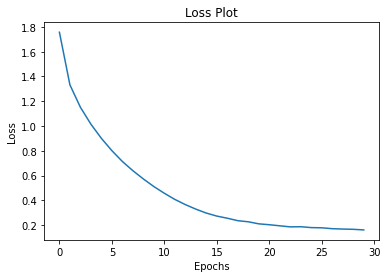

In [41]:
# Loss curve
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [42]:
# This function generate captions on evaluation data
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))
    hidden = decoder.reset_state(batch_size=1)
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    features = encoder(img_tensor_val)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []
    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])
        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot
        dec_input = tf.expand_dims([predicted_id], 0)
    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [43]:
# This function is used to plot attentions  
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Prediction Caption: ٹینس ریکیٹ تھامے ہوئے شخص پیلے رنگ کی ٹینس بال کو مارتا ہے <end>
BLEU Score: 0.9199732720441995


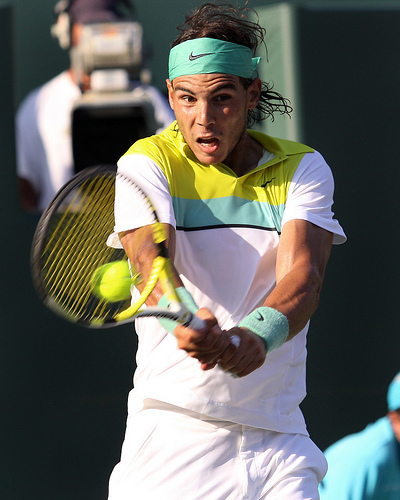

In [44]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
result, attention_plot = evaluate(image)
real = list(df[df['Images']==image]['Captions'])
cleaned = []
for i in range(len(real)):
    cleaned.append(real[i][7:-5])
predicted = ' '.join(result)
print ('Prediction Caption:', predicted)
bs = sentence_bleu(cleaned, predicted)
print('BLEU Score:',bs)
cv2_imshow(cv2.imread(image))

In [45]:
score = 0
for i in range (0,len(img_name_val),5):
    image = img_name_val[i]
    result, attention_plot = evaluate(image)
    real = list(df[df['Images']==image]['Captions'])
    cleaned = []
    for i in range(len(real)):
        cleaned.append(real[i][7:-5])
    predicted = ' '.join(result)
    score += sentence_bleu(cleaned, predicted)
val_bleu = score/len(img_name_val)*5
print("BLEU score on validation data: ",val_bleu)

BLEU score on validation data:  0.7726217713856629


73728/64400 [==================================] - 0s 0us/step
Prediction Caption: ایک ہیڈ تر پوشاک بورڈنگ کر رہا ہے اور گرے آسمان میں سمندر میں نیلے پانی میں سمندر میں نیلے رنگ کے تر پوشاک پہنے ہوئے ایک شخص نشیبی پانی میں سامان کرتا ہوا ہے <end>


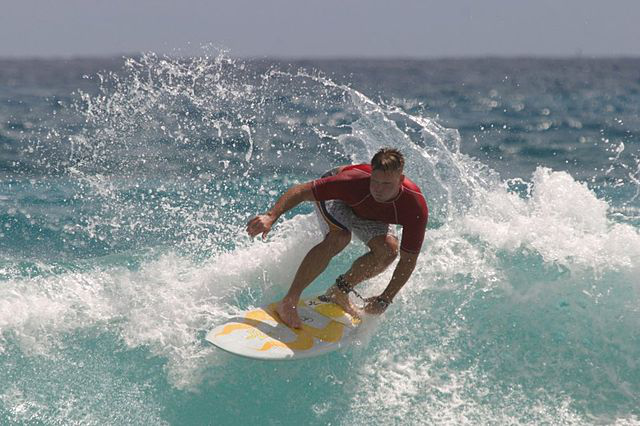

In [46]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-8:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
Image.open(image_path)

24576/15892 [==============================================] - 0s 0us/step
Prediction Caption: پیلے اور پیلے رنگ کی بندہ ایک شخص سکی پر برف لیے ہیلمٹ ولا کھیلتا ہوا ایک سنو بورڈ پر سوار ایک شخص برف سے ڈھانپ رہا ہے <end>


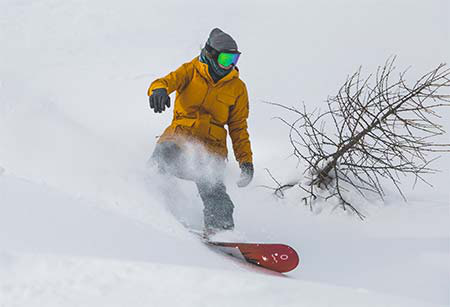

In [47]:
image_url = 'https://www.snowboard-asylum.com/media/TSA%20Snowboard%20Guide/Snowboard%20Binding%20Buying%20Guide/SS20/Board-Med-Flex.jpg'
image_extension = image_url[-18:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
Image.open(image_path)